In [106]:
%%markdown 
**MNIST Notebook**: *digit recognizer competition on kaggle with pytorch*

**MNIST Notebook**: *digit recognizer competition on kaggle with pytorch*


In [9]:
# imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
#plot on notebook matplotlib
%matplotlib inline

In [107]:
#check if we have GPU available
is_cuda=False
if torch.cuda.is_available():
    is_cuda = True

In [109]:
%%markdown 
## **Train set**

## **Train set**


In [12]:
#train set
train = pd.read_csv('input/train.csv')
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#label counts
count_labels = Counter(train['label'])
print(count_labels)

In [113]:
%%markdown 
**visualize label count**

**visualize label count**


In [ ]:
#visualize label count
sns.countplot(train['label'])

In [15]:
#features
x_train = (train.iloc[:,1:].values).astype('float32')
#labels
y_train = train.iloc[:,0].values.astype('int32')

In [116]:
%%markdown 
**plot some values**

**plot some values**


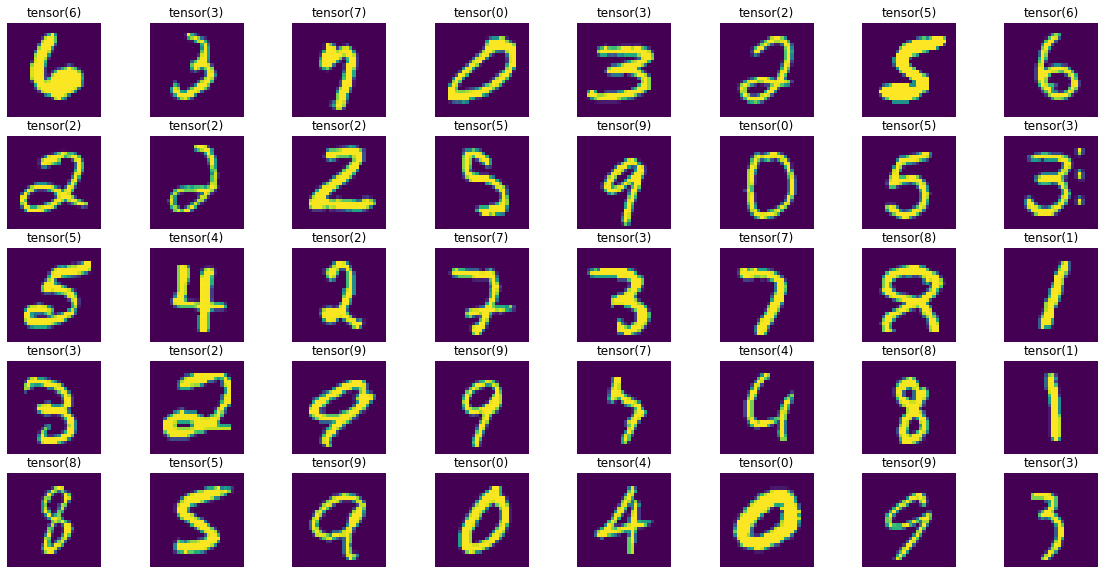

In [115]:
#plot some values
plt.figure(figsize=(20,10))
x, y = 8, 5
for i in range(40):  
    plt.subplot(y, x, i+1)
    plt.title(str(y_train[i]))
    plt.imshow(x_train[i].reshape((28,28)))
    plt.axis("off")
plt.show()

In [123]:
%%markdown 
**normalize the input data**
<br>
**Then split our data to train/validation sets**

**normalize the input data**
<br>
**Then split our data to train/validation sets**


In [17]:
#normalize the input data
x_train = x_train/255.0

#split into train and validation for our case 80 % train and 20% val
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2) 

In [42]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')

x_train shape: torch.Size([33600, 784])
33600 train samples
8400 validation samples


In [ ]:
%%markdown 
**make Feature and label to tensors **

In [19]:
# labe and features tensors
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)
x_val = torch.from_numpy(x_val)
y_val = torch.from_numpy(y_val).type(torch.LongTensor)

In [125]:
%%markdown 
**Define our constants and prepare our data loader**

**Define our constants and prepare our data loader**


In [21]:
BATCH_SIZE = 64
EPOCHS = 20
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10
train = torch.utils.data.TensorDataset(x_train,y_train)
val = torch.utils.data.TensorDataset(x_val, y_val)
data_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE)

In [144]:
%%markdown 
## **Define model Class**
**Input image --> Convolution layer(16 nodes) --> Batch Normalization --> Dropout(20%) --> Max Pooling(Kernel (2,2)) 
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;--> Convolution layer(32 nodes) --> Batch Normalization --> Dropout(50%) --> Max Pooling(Kernel (2,2)) 
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;--> fully connected layer(128 nodes) --> fully connected layer(64 nodes) --> fully connected layer(10 nodes) Which represents the Output Layer**

## **Define model Class**
**Input image --> Convolution layer(16 nodes) --> Batch Normalization --> Dropout(20%) --> Max Pooling(Kernel (2,2)) 
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;--> Convolution layer(32 nodes) --> Batch Normalization --> Dropout(50%) --> Max Pooling(Kernel (2,2)) 
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;--> fully connected layer(128 nodes) --> fully connected layer(64 nodes) --> fully connected layer(10 nodes) Which represents the Output Layer**


In [22]:
class CNN_MNIST(nn.Module):
    """
    Our model's Class inherit from nn.Module
    """
    def __init__(self):
        super(CNN_MNIST, self).__init__()
        #Conv1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.drop1 = nn.Dropout2d(p=0.2)
        
        #Conv2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.drop2 = nn.Dropout2d(p=0.5)
        
        #Conv3 
        # self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        # self.drop3 = nn.Dropout2d(p=0.5)
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.drop1(self.batch_norm1(self.conv1(x)))))
        x = self.pool(F.relu(self.drop2(self.batch_norm2(self.conv2(x)))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
%%markdown 
**Define our loss and optimizer**

In [23]:
model = CNN_MNIST() #our model
error = nn.CrossEntropyLoss() #Cross entropy loss because we have many classes (10)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.003, momentum=0.5) # SGD Optimizer

In [ ]:
%%markdown 
**Fit method to train the model**

In [37]:
def fit(model, data, phase='training', batch_size = 64, is_cuda=False):
    """
    Method to train the model
    :input model:(CNN_MNIST) Our model (in this case is the CNN_MNIST model class)
    :input data:(dataLoader) our training / validation data to train the model on and validate
    :input phase: (String) 'training' to train model 'validation' to make predictions and validate the model
    :input batch_size: (int) batch size we feed to our neural network
    :input is_cuda: (Bool) wheather to use cuda or not (GPU)
    :return loss: (float) loss value for one epoch
    :return accuracy: (float) accuracy value for one epoch
    """
    if phase == 'training':
        model.train()
    elif phase == 'validation':
        model.eval()
    loss_values = 0.0
    correct_values = 0
    for batch_idx, (image, label) in enumerate(data):
        if is_cuda:
            image, label = image.cuda(), label.cuda()
        try:
            image, label = Variable(image.view(batch_size, 1, 28, 28)), Variable(label)
        except:
            image, label = Variable(image.view(int(batch_size/4), 1, 28, 28)), Variable(label)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(image)
        #print(output)
        loss = error(output, label)
        loss_values += loss.data
        predictions = output.data.max(dim=1, keepdim=True)[1]
        correct_values += predictions.eq(label.data.view_as(predictions)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    loss = loss_values / len(data.dataset)
    accuracy = 100. * correct_values / len(data.dataset)
    print(f'\n{phase} loss is {loss:{5}.{2}} and {phase} accuracy is \
          {accuracy:{10}.{4}}\n=============================================\')
    return loss, accuracy

In [ ]:
#validation / traing lists for accuracy and loss values during training
train_loss_list, val_loss_list = [], []
train_accuracy_list, val_accuracy_list = [], []

for epoch in range(EPOCHS):
    print(epoch)
    #Training
    train_epoch_loss, train_epoch_accuracy = fit(model, data_loader, batch_size=BATCH_SIZE) 
    #Validating
    val_epoch_loss, val_epoch_accuracy = fit(model, val_loader, phase='validation', batch_size=BATCH_SIZE)
    
    train_loss_list.append(train_epoch_loss)
    train_accuracy_list.append(train_epoch_accuracy)
    val_loss_list.append(val_epoch_loss)
    val_accuracy_list.append(val_epoch_accuracy)


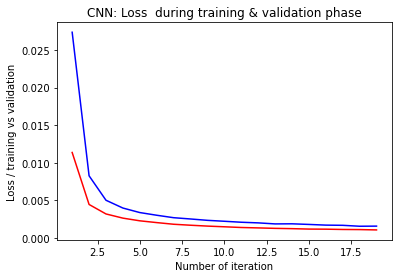

In [40]:
#LOSS PLOT
plt.plot(range(1, len(train_loss_list)+1), train_loss_list,'b', label = 'Training')
plt.plot(range(1, len(val_loss_list)+1), val_loss_list,'r', label = 'Validation')
plt.xlabel("Number of iteration")
plt.ylabel("Loss / training vs validation")
plt.title("CNN: Loss  during training & validation phase")
plt.show()

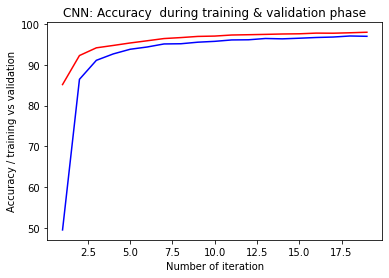

In [41]:
#ACCURACY PLOT
plt.plot(range(1, len(train_accuracy_list)+1), train_accuracy_list,'b', label = 'Training')
plt.plot(range(1, len(val_accuracy_list)+1), val_accuracy_list,'r', label = 'Validation')
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy / training vs validation")
plt.title("CNN: Accuracy  during training & validation phase")
plt.show()

In [70]:
def predict(model, data):
    model.eval()
    test_predictions = torch.LongTensor()
    for batch_idx, (image,) in enumerate(data):
        image = Variable(image.view(1, 1, 28, 28))
        output = model(image)
        prediction = output.data.max(dim=1, keepdim=True)[1]
        test_predictions = torch.cat((test_predictions, prediction), dim=0)
    return test_predictions

In [73]:
#TEST SET
test_set= pd.read_csv("input/test.csv")
print(test_set.shape)
x_test = test_set.values.astype('float32')
X_test = x_test/255.0 # Normalize
X_test = torch.from_numpy(X_test) #make it as torch tensor
test = torch.utils.data.TensorDataset(X_test)
test_loader = torch.utils.data.DataLoader(test)
predictions = predict(model, test_loader)

(28000, 784)


In [74]:
pred_df = pd.DataFrame(np.c_[np.arange(1, len(test_set)+1)[:,None], predictions.numpy()], 
                      columns=['ImageId', 'Label'])
pred_df.to_csv('submission.csv', index=False)

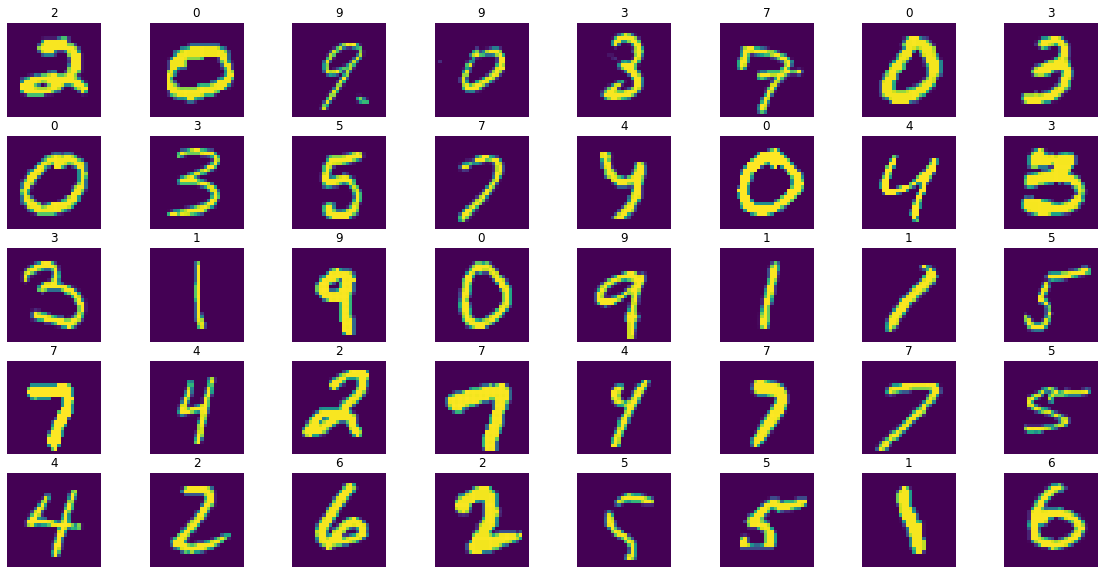

In [99]:
plt.figure(figsize=(20,10))
x, y = 8, 5
for i in range(40):  
    plt.subplot(y, x, i+1)
    plt.title(str(pred_df.iloc[i,1]))
    plt.imshow(x_test[i].reshape((28,28)))
    plt.axis("off")
plt.show()